# Merging Policy

Abhinav Madahar <abhinav.madahar@rutgers.edu>, James Abello Monedero <abelloj@rutgers.edu>

<br />

We want to move away from designing just algorithms so that we can start designing meta-algorithms.
With the new chunk-based SparseNet algorithm, we create SparseNets of chunks.
We combine the chunks' SparseNets to get new SparseNets for the chunks.
It's based on the assumption that
$$
    \mathrm{combine}(\mathrm{sparsenet}(A), \mathrm{sparsenet}(B)) = \mathrm{sparsenet}(\mathrm{combine}(A, B)).
$$

In [7]:
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from unionfind import UnionFind  # by GitHub user deehzee
from graph.sparsenet import sparsenet
from functools import reduce
import random
import math

Let's get a sample graph to demonstrate the algorithm.

In [8]:
G = nx.gnm_random_graph(2 ** 15, 4 * 2 ** 15)
G = G.subgraph(next(nx.connected_components(G)))

Let's load in that algorithm.
For now, we just accept a `combine` parameter which represents the algorithm which combines two sparsenets appropriately.

In [10]:
def fast_sparsenet(edges_source, combine, k:int = 14) -> nx.Graph:
    overall_sparsenet = nx.Graph()
    while True:
        sparsenets = []
        uf = UnionFind()
        edges = list(itertools.islice(edges_source, 2 ** k))
        if len(edges) == 0:
            return overall_sparsenet
        
        g = nx.empty_graph()
        for src, dest in edges:
            uf.union(src, dest)
            g.add_edge(src, dest)
        
        for i, component in enumerate(uf.components()):
            h = g.subgraph(component)
            distance_matrix = nx.floyd_warshall_numpy(h)
            sn_generator = sparsenet(h, distance_matrix, { node:i for i, node in enumerate(h.nodes()) })
            edges_included_in_sn = set(sum(([(src, dest) for src, dest in zip(path, path[1:])] for path in sn_generator), []))
            leftover = set(h.edges()) - edges_included_in_sn
            extras_wanted = int(h.number_of_nodes() * (math.log2(h.number_of_nodes()) - 1)) + 1
            extra_edges = random.sample(leftover, min(extras_wanted, len(leftover)))
            sparsenets.append(h.edge_subgraph(set(extra_edges) | edges_included_in_sn))

        plt.figure(figsize=(20, 20))
        plt.title('SparseNets of different components')
        for i, sn in enumerate(sorted(sparsenets, key=lambda sn: -sn.number_of_nodes())):
            plt.subplot(int(len(sparsenets) ** 0.5) + 1, int(len(sparsenets) ** 0.5 + 1) + 1, i+1)
            pos = nx.spring_layout(sn)
            nx.draw_networkx_nodes(sn, pos=pos, node_size=1, node_color='blue' if nx.is_tree(sn) else 'red')
            nx.draw_networkx_edges(sn, pos=pos, alpha=0.3)
        plt.show()
        
        original_n = overall_sparsenet.number_of_nodes()
        overall_sparsenet = reduce(nx.compose, sparsenets, overall_sparsenet)
        new_n = overall_sparsenet.number_of_nodes()
        if original_n == new_n:
            return overall_sparsenet

Now, let's create that combining algorithm.

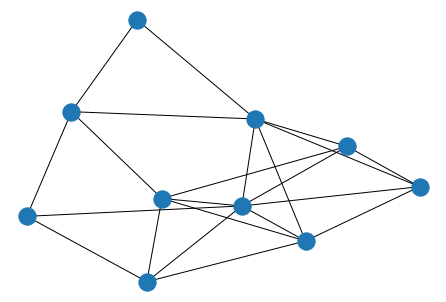

In [24]:
def combine_on_intersection(sparsenet_a: nx.Graph, sparsenet_b: nx.Graph) -> nx.Graph:
    intersection = set(sparsenet_a.nodes) & set(sparsenet_b.nodes)
    if len(intersection) == 0:
        return nx.union(sparsenet_a, sparsenet_b)
    elif len(intersection) == 1:
        return nx.compose(sparsenet_a, sparsenet_b)
    elif len(intersection) == 2:
        return None

sna = nx.gnm_random_graph(10, 20)
sna.add_edge(0, 1)
sna.add_edge(0, 2)
sna.add_edge(1, 2)
sna.add_edge(1, 3)
sna.add_edge(1, 4)

snb = 
snb.add_edge(2, 3)
snb.add_edge(2, 4)
snb.add_edge(3, 4)

nx.draw(sna)